In [1]:
from perses.analysis import utils
from openmmtools.multistate import MultiStateReporter, MultiStateSamplerAnalyzer
from simtk import unit
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from perses.analysis import utils

from openmmtools.constants import kB
KT_KCALMOL = kB * 298 * unit.kelvin / unit.kilocalories_per_mole

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Given a path, get dg and ddg
def analyze(path):
    reporter = MultiStateReporter(path)
    analyzer = MultiStateSamplerAnalyzer(reporter)
    f_ij, df_ij = analyzer.get_free_energy()
    f = f_ij[0,-1] # units = kT
#     f = f_ij[0,-1] * analyzer.kT
#     dg = f.in_units_of(unit.kilocalories_per_mole)
    df = df_ij[0, -1]
#     df = df_ij[0, -1] * analyzer.kT
#     ddg = df.in_units_of(unit.kilocalories_per_mole)
    return f, df

def analyze_dom(path):
    reporter = MultiStateReporter(path)
    ncfile = utils.open_netcdf(path)
    n_iterations = ncfile.variables['last_iteration'][0]
    print(f"n_iterations: {n_iterations}")
    dg, ddg = list(), list()
#     iterations_to_analyze = list(range (1, n_iterations, 500)) + [int(n_iterations-1)]
#     print(iterations_to_analyze) # check that this is giving me the last avail iteration
#     for step in iterations_to_analyze: 
#         analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=step)
#         f_ij, df_ij = analyzer.get_free_energy()
#         dg.append(f_ij[0,-1])
#         ddg.append(df_ij[0,-1])
    # Get final free energy
    analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=n_iterations)
    f_ij, df_ij = analyzer.get_free_energy()
    dg.append(f_ij[0,-1])
    ddg.append(df_ij[0,-1])
    return np.array(dg), np.array(ddg)

### 5 ns N501Y (repex/31/3/0)

In [3]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [4]:
main_dir = 31
sub_dir = 3
titles = ['N501Y']

In [14]:
for r in tqdm_notebook([0]):
    print (f"replicate {r}")
    output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/'
    
    print("analyzing complex")
    complex_path = os.path.join(output_dir, f"{r}_complex.nc")
    complex_dg, complex_ddg = analyze_dom(complex_path)
    print("analyzing apo")
    apo_path = os.path.join(output_dir, f"{r}_apo.nc")
    apo_dg, apo_ddg = analyze_dom(apo_path)

    results = np.array([complex_dg, complex_ddg, apo_dg, apo_ddg])
    with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy', 'wb') as f:
        np.save(f, results)

  0%|          | 0/1 [00:00<?, ?it/s]

replicate 0
analyzing complex
n_iterations: 5000


analyzing apo
n_iterations: 5000


In [16]:
# Read the dicts in and compute free energies (kT)
d_results = {}
for r in [0]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[r] = results
        complex_dg, complex_ddg, apo_dg, apo_ddg = [result[-1] for result in results]
        print(f"{r} complex: {complex_dg} ({complex_ddg}) kT")
        print(f"{r} apo: {apo_dg} ({apo_ddg}) kT")
        binding_dg = complex_dg - apo_dg
        binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
        print(f"{r} DDG: {binding_dg} ({binding_ddg}) kT")
        print()


0 complex: 122.43736768923483 (0.9068850135311671) kT
0 apo: 110.20324855702171 (0.3821731064401907) kT
0 DDG: 12.234119132213124 (0.9841223049263594) kT



In [18]:
# Read the dicts in and compute free energies (kcal/mol)
d_results = {}
for r in [0]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[r] = results
        complex_dg, complex_ddg, apo_dg, apo_ddg = [result[-1]*KT_KCALMOL for result in results]
        print(f"{r} complex: {complex_dg} ({complex_ddg}) kcal/mol")
        print(f"{r} apo: {apo_dg} ({apo_ddg}) kcal/mol")
        binding_dg = complex_dg - apo_dg
        binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
        print(f"{r} DDG: {binding_dg} ({binding_ddg}) kcal/mol")
        print()



0 complex: 72.50580142966857 (0.5370453967740314) kcal/mol
0 apo: 65.26091672487313 (0.22631789534747085) kcal/mol
0 DDG: 7.244884704795439 (0.5827843065411813) kcal/mol



In [ ]:
# Generate replica mixing plots
for r in [0]:
    print (f"replicate {r} complex")
    path = f"/data/chodera/zhangi/perses_benchmark/repex/31/{sub_dir}/{r}/{r}_complex.nc"
    utils.plot_replica_mixing(path, title=f"{titles[r]} complex replicate {r}", filename=f"{path[:-3]}_replicas.png")
    plt.clf()
    
    print (f"replicate {r} apo")
    path = f"/data/chodera/zhangi/perses_benchmark/repex/31/{sub_dir}/{r}/{r}_apo.nc"
    utils.plot_replica_mixing(path, title=f"{titles[r]} apo replicate {r}", filename=f"{path[:-3]}_replicas.png")
    plt.clf()


In [5]:
import os
import pickle
import logging 
from openmmtools.multistate import MultiStateReporter
import tqdm
import numpy as np

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt
import matplotlib.transforms as transforms


In [6]:
out_dir = "/data/chodera/zhangi/perses_benchmark/repex/31/3/0/"
i = os.path.basename(os.path.dirname(out_dir))
phase = 'complex'
aa = 'ASN'.lower()
length = '1ns'
with open(os.path.join(out_dir, f"{i}_{phase}.pickle"), "rb") as f:
    htf = pickle.load(f)


In [7]:
reporter = MultiStateReporter(os.path.join(out_dir, f"{i}_{phase}.nc"), 'r')


In [10]:
states = range(12)
state_neighbors = []
for first, second in zip(states, states[1:]):
    state_neighbors.append((first, second))

In [11]:
# Note this was edited to work for swap-neighbors (there can be nans)
acceptance_rates_all = []
for pair in tqdm.tqdm(state_neighbors):
    state_i = pair[0]
    state_j = pair[1]
    acceptance_rates = []
    for iteration in range(0, 9820):
        acceptance_rate_raw = reporter.read_mixing_statistics(iteration)[0][state_i][state_j] / reporter.read_mixing_statistics(iteration)[1][state_i][state_j]
        if not np.isnan(acceptance_rate_raw):
            acceptance_rates.append(acceptance_rate_raw)
    acceptance_rates_all.append(acceptance_rates)

 91%|█████████ | 10/11 [04:28<00:26, 26.89s/it]


IndexError: index 11 is out of bounds for axis 0 with size 11

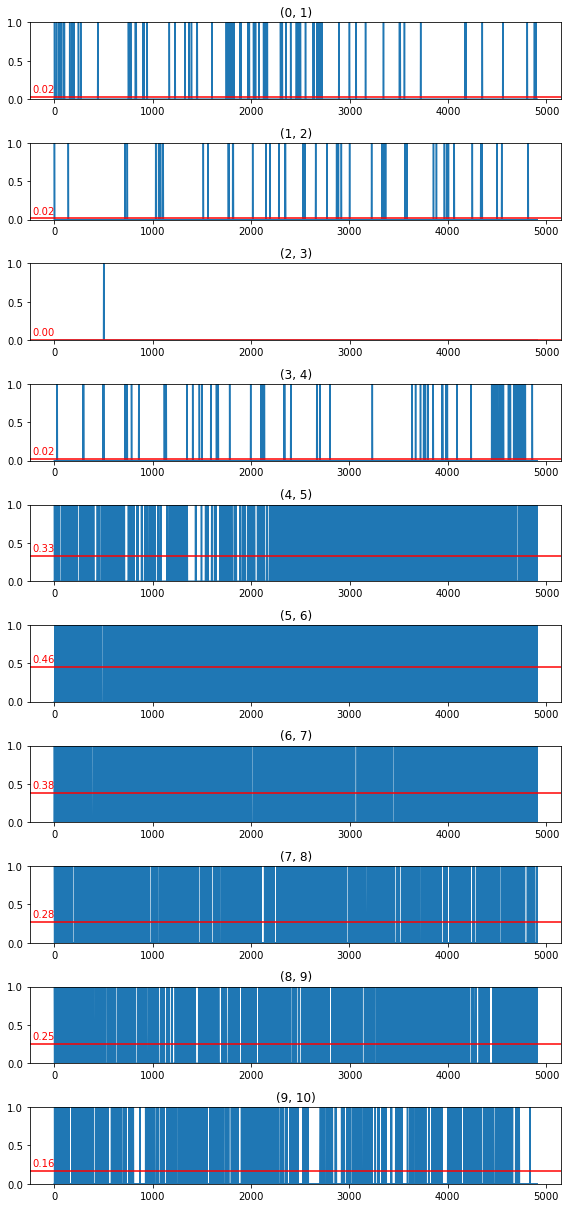

In [12]:
cols = 1
rows = 12
plt.figure(figsize=(8, 20))
gs = plt.GridSpec(rows, cols)
for i, (pair, acceptance_rates) in enumerate(zip(state_neighbors, acceptance_rates_all)):
    plt.subplot(gs[i,0])
    plt.plot(acceptance_rates)
    plt.title(pair)
    plt.ylim([0, 1])
    mean = np.mean(acceptance_rates)
    plt.axhline(y=mean, color="red")

#     trans = transforms.blended_transform_factory(
#         plt.yticks()[0].get_transform(), plt.transData)
    plt.text(0, mean + 0.1, "{:.2f}".format(mean), color="red", 
            ha="right", va="center")
plt.tight_layout()
plt.show()

### 5 ns Y501N (repex/31/4/0)

In [5]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [6]:
main_dir = 31
sub_dir = 4
titles = ['Y501N']

In [7]:
for r in tqdm_notebook([0]):
    print (f"replicate {r}")
    output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/'
    
    print("analyzing complex")
    complex_path = os.path.join(output_dir, f"{r}_complex.nc")
    complex_dg, complex_ddg = analyze_dom(complex_path)
    print("analyzing apo")
    apo_path = os.path.join(output_dir, f"{r}_apo.nc")
    apo_dg, apo_ddg = analyze_dom(apo_path)

    results = np.array([complex_dg, complex_ddg, apo_dg, apo_ddg])
    with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy', 'wb') as f:
        np.save(f, results)

  0%|          | 0/1 [00:00<?, ?it/s]

replicate 0
analyzing complex
n_iterations: 5000


analyzing apo
n_iterations: 5000


In [8]:
# Read the dicts in and compute free energies (kT)
d_results = {}
for r in [0]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[r] = results
        complex_dg, complex_ddg, apo_dg, apo_ddg = [result[-1] for result in results]
        print(f"{r} complex: {complex_dg} ({complex_ddg}) kT")
        print(f"{r} apo: {apo_dg} ({apo_ddg}) kT")
        binding_dg = complex_dg - apo_dg
        binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
        print(f"{r} DDG: {binding_dg} ({binding_ddg}) kT")
        print()


0 complex: -113.89078820725683 (1.0286437496998846) kT
0 apo: -111.83756798159254 (0.2748612283149982) kT
0 DDG: -2.0532202256642904 (1.0647331396305217) kT



In [9]:
# Read the dicts in and compute free energies (kcal/mol)
d_results = {}
for r in [0]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[r] = results
        complex_dg, complex_ddg, apo_dg, apo_ddg = [result[-1]*KT_KCALMOL for result in results]
        print(f"{r} complex: {complex_dg} ({complex_ddg}) kcal/mol")
        print(f"{r} apo: {apo_dg} ({apo_ddg}) kcal/mol")
        binding_dg = complex_dg - apo_dg
        binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
        print(f"{r} DDG: {binding_dg} ({binding_ddg}) kcal/mol")
        print()



0 complex: -67.44462928493566 (0.6091493215283093) kcal/mol
0 apo: -66.22873922797812 (0.1627692102259586) kcal/mol
0 DDG: -1.2158900569575337 (0.630520984358159) kcal/mol



In [ ]:
# Generate replica mixing plots
for r in [0]:
    print (f"replicate {r} complex")
    path = f"/data/chodera/zhangi/perses_benchmark/repex/31/{sub_dir}/{r}/{r}_complex.nc"
    utils.plot_replica_mixing(path, title=f"{titles[r]} complex replicate {r}", filename=f"{path[:-3]}_replicas.png")
    plt.clf()
    
    print (f"replicate {r} apo")
    path = f"/data/chodera/zhangi/perses_benchmark/repex/31/{sub_dir}/{r}/{r}_apo.nc"
    utils.plot_replica_mixing(path, title=f"{titles[r]} apo replicate {r}", filename=f"{path[:-3]}_replicas.png")
    plt.clf()


### 5 ns K417N (repex/31/5/0)

In [6]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [14]:
main_dir = 31
sub_dir = 5
titles = ['K417N']

In [15]:
for r in tqdm_notebook([0]):
    print (f"replicate {r}")
    output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/'
    
    print("analyzing complex")
    complex_path = os.path.join(output_dir, f"{r}_complex.nc")
    complex_dg, complex_ddg = analyze_dom(complex_path)
    print("analyzing apo")
    apo_path = os.path.join(output_dir, f"{r}_apo.nc")
    apo_dg, apo_ddg = analyze_dom(apo_path)

    results = np.array([complex_dg, complex_ddg, apo_dg, apo_ddg])
    with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy', 'wb') as f:
        np.save(f, results)

  0%|          | 0/1 [00:00<?, ?it/s]

replicate 0
analyzing complex
n_iterations: 5000


analyzing apo
n_iterations: 5000


In [16]:
# Read the dicts in and compute free energies (kT)
d_results = {}
for r in [0]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[r] = results
        complex_dg, complex_ddg, apo_dg, apo_ddg = [result[-1] for result in results]
        print(f"{r} complex: {complex_dg} ({complex_ddg}) kT")
        print(f"{r} apo: {apo_dg} ({apo_ddg}) kT")
        binding_dg = complex_dg - apo_dg
        binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
        print(f"{r} DDG: {binding_dg} ({binding_ddg}) kT")
        print()


0 complex: -247.96594648258312 (1.2011439472425804) kT
0 apo: -251.72381610737628 (0.5187872248412405) kT
0 DDG: 3.757869624793159 (1.3083909838637542) kT



In [17]:
# Read the dicts in and compute free energies (kcal/mol)
d_results = {}
for r in [0]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[r] = results
        complex_dg, complex_ddg, apo_dg, apo_ddg = [result[-1]*KT_KCALMOL for result in results]
        print(f"{r} complex: {complex_dg} ({complex_ddg}) kcal/mol")
        print(f"{r} apo: {apo_dg} ({apo_ddg}) kcal/mol")
        binding_dg = complex_dg - apo_dg
        binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
        print(f"{r} DDG: {binding_dg} ({binding_ddg}) kcal/mol")
        print()



0 complex: -146.84217748473185 (0.7113016734259316) kcal/mol
0 apo: -149.06753853223003 (0.3072189823948254) kcal/mol
0 DDG: 2.2253610474981826 (0.7748119602601928) kcal/mol



In [ ]:
# Generate replica mixing plots
for r in [0]:
    print (f"replicate {r} complex")
    path = f"/data/chodera/zhangi/perses_benchmark/repex/31/{sub_dir}/{r}/{r}_complex.nc"
    utils.plot_replica_mixing(path, title=f"{titles[r]} complex replicate {r}", filename=f"{path[:-3]}_replicas.png")
    plt.clf()
    
    print (f"replicate {r} apo")
    path = f"/data/chodera/zhangi/perses_benchmark/repex/31/{sub_dir}/{r}/{r}_apo.nc"
    utils.plot_replica_mixing(path, title=f"{titles[r]} apo replicate {r}", filename=f"{path[:-3]}_replicas.png")
    plt.clf()


### 5 ns N417K (repex/31/6/0)

In [3]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [4]:
main_dir = 31
sub_dir = 6
titles = ['N417K']

In [5]:
for r in tqdm_notebook([0]):
    print (f"replicate {r}")
    output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/'
    
    print("analyzing complex")
    complex_path = os.path.join(output_dir, f"{r}_complex.nc")
    complex_dg, complex_ddg = analyze_dom(complex_path)
    print("analyzing apo")
    apo_path = os.path.join(output_dir, f"{r}_apo.nc")
    apo_dg, apo_ddg = analyze_dom(apo_path)

    results = np.array([complex_dg, complex_ddg, apo_dg, apo_ddg])
    with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy', 'wb') as f:
        np.save(f, results)

  0%|          | 0/1 [00:00<?, ?it/s]

replicate 0
analyzing complex
n_iterations: 5000


analyzing apo
n_iterations: 5000


In [7]:
# Read the dicts in and compute free energies (kcal/mol)
d_results = {}
for r in [0]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[r] = results
        complex_dg, complex_ddg, apo_dg, apo_ddg = [result[-1]*KT_KCALMOL for result in results]
        print(f"{r} complex: {complex_dg} ({complex_ddg}) kcal/mol")
        print(f"{r} apo: {apo_dg} ({apo_ddg}) kcal/mol")
        binding_dg = complex_dg - apo_dg
        binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
        print(f"{r} DDG: {binding_dg} ({binding_ddg}) kcal/mol")
        print()



0 complex: -20.228300400274435 (0.5712253488599995) kcal/mol
0 apo: -16.23686754501904 (0.2928410363662453) kcal/mol
0 DDG: -3.9914328552553933 (0.641914536180857) kcal/mol



In [8]:
# Generate replica mixing plots
for r in [0]:
    print (f"replicate {r} complex")
    path = f"/data/chodera/zhangi/perses_benchmark/repex/31/{sub_dir}/{r}/{r}_complex.nc"
    utils.plot_replica_mixing(path, title=f"{titles[r]} complex replicate {r}", filename=f"{path[:-3]}_replicas.png")
    plt.clf()
    
    print (f"replicate {r} apo")
    path = f"/data/chodera/zhangi/perses_benchmark/repex/31/{sub_dir}/{r}/{r}_apo.nc"
    utils.plot_replica_mixing(path, title=f"{titles[r]} apo replicate {r}", filename=f"{path[:-3]}_replicas.png")
    plt.clf()


replicate 0 complex
replicate 0 apo


<Figure size 1080x1584 with 0 Axes>

<Figure size 1080x1584 with 0 Axes>

### 5 ns E484K (repex/31/7/0)

In [9]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [10]:
main_dir = 31
sub_dir = 7

In [12]:
for r in tqdm_notebook([0]):
    print (f"replicate {r}")
    output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/'
    
    print("analyzing complex")
    complex_path = os.path.join(output_dir, f"{r}_complex.nc")
    complex_dg, complex_ddg = analyze_dom(complex_path)
    print("analyzing apo")
    apo_path = os.path.join(output_dir, f"{r}_apo.nc")
    apo_dg, apo_ddg = analyze_dom(apo_path)

    results = np.array([complex_dg, complex_ddg, apo_dg, apo_ddg])
    with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy', 'wb') as f:
        np.save(f, results)

  0%|          | 0/1 [00:00<?, ?it/s]

replicate 0
analyzing complex
n_iterations: 5000


analyzing apo
n_iterations: 5000


In [13]:
# Read the dicts in and compute free energies (kcal/mol)
d_results = {}
for r in [0]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[r] = results
        complex_dg, complex_ddg, apo_dg, apo_ddg = [result[-1]*KT_KCALMOL for result in results]
        print(f"{r} complex: {complex_dg} ({complex_ddg}) kcal/mol")
        print(f"{r} apo: {apo_dg} ({apo_ddg}) kcal/mol")
        binding_dg = complex_dg - apo_dg
        binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
        print(f"{r} DDG: {binding_dg} ({binding_ddg}) kcal/mol")
        print()



0 complex: -98.66386178829801 (0.8991960214512452) kcal/mol
0 apo: -100.78262901529315 (0.38811246607420763) kcal/mol
0 DDG: 2.1187672269951463 (0.9793797891093889) kcal/mol



In [15]:
def plot_series(dg, ddg, r, phase, title):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(10,2*3), squeeze=True)
    for r in range(len(dg)):
        dg_discarded = dg[r][1:] # 1 * 500 = 500 ps discarded
        ddg_discarded = ddg[r][1:]
    
        # dg
        ax = axes[0]
        x = [(j)*0.5 + 0.5 for j in range(len(dg_discarded))] # *0.2 bc computing energy every 200 ps
        y = dg_discarded
        ax.plot(x, y, color=sns.color_palette()[r])
        ax.fill_between(x, y - ddg_discarded, y + ddg_discarded, alpha=0.5)

        # ddg
        ax = axes[1]
        x = [(j)*0.5 + 0.5 for j in range(len(ddg_discarded))]
        y = ddg_discarded
        ax.plot(x, y, color=sns.color_palette()[0])

    axes[0].set_ylabel("dG (kT)")
    axes[1].set_ylabel("ddG (kT)")
    axes[1].set_xlabel("$t_{repex}$ (ns)")
    
    axes[0].set_title(f"{title} {phase}")
    plt.show()
#     plt.savefig(f"/data/chodera/zhangi/perses_benchmark/repex/31/1/{r}/{r}_{phase}_series.png", dpi=500)
#     plt.clf()

0


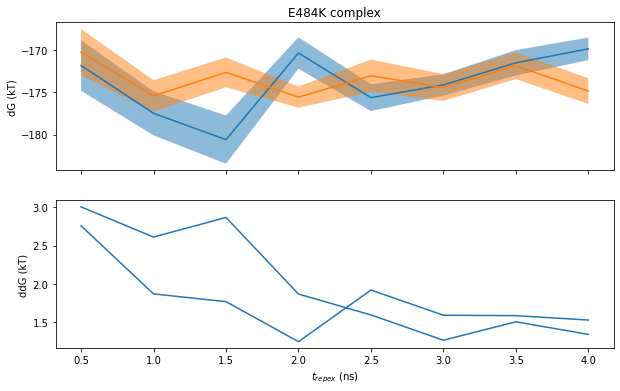

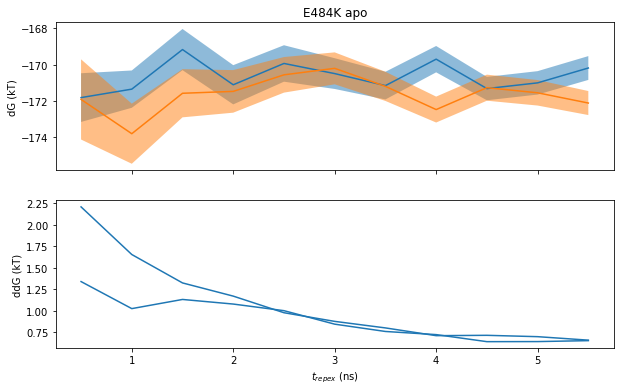

In [16]:
#### MAKE SURE TO CHANGE PATH IN PLOT_SERIES() ####

titles = ['E484K']

# Generate dg, ddg, and discrepancy vs. time plots
for i, title in enumerate(titles):
    print(i)
    complex_dg = []
    complex_ddg = []
    apo_dg = []
    apo_ddg = []
    for r in [0, 1]:
        complex_dg.append(d_results[r][0])
        complex_ddg.append(d_results[r][1])
        apo_dg.append(d_results[r][2])
        apo_ddg.append(d_results[r][3])
    plot_series(complex_dg, complex_ddg, r, 'complex', title)
    plot_series(apo_dg, apo_ddg, r, 'apo', title)
    

    


In [ ]:
# Generate replica mixing plots
for r in [0, 1]:
    print (f"replicate {r} complex")
    path = f"/data/chodera/zhangi/perses_benchmark/repex/31/{sub_dir}/{r}/{r}_complex.nc"
    utils.plot_replica_mixing(path, title=f"{titles[i]} complex replicate {r}", filename=f"{path[:-3]}_replicas.png")
    plt.clf()
    
    print (f"replicate {r} apo")
    path = f"/data/chodera/zhangi/perses_benchmark/repex/31/{sub_dir}/{r}/{r}_apo.nc"
    utils.plot_replica_mixing(path, title=f"{titles[i]} apo replicate {r}", filename=f"{path[:-3]}_replicas.png")
    plt.clf()


### 5 ns K484E (repex/31/8/0)

In [14]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [15]:
main_dir = 31
sub_dir = 8

In [16]:
for r in tqdm_notebook([0]):
    print (f"replicate {r}")
    output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/'
    
    print("analyzing complex")
    complex_path = os.path.join(output_dir, f"{r}_complex.nc")
    complex_dg, complex_ddg = analyze_dom(complex_path)
    print("analyzing apo")
    apo_path = os.path.join(output_dir, f"{r}_apo.nc")
    apo_dg, apo_ddg = analyze_dom(apo_path)

    results = np.array([complex_dg, complex_ddg, apo_dg, apo_ddg])
    with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy', 'wb') as f:
        np.save(f, results)

  0%|          | 0/1 [00:00<?, ?it/s]

replicate 0
analyzing complex
n_iterations: 5000


analyzing apo
n_iterations: 5000


In [19]:
# Read the dicts in and compute free energies (kcal/mol)
d_results = {}
for r in [0]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[r] = results
        complex_dg, complex_ddg, apo_dg, apo_ddg = [result[-1]*KT_KCALMOL for result in results]
        print(f"{r} complex: {complex_dg} ({complex_ddg}) kcal/mol")
        print(f"{r} apo: {apo_dg} ({apo_ddg}) kcal/mol")
        binding_dg = complex_dg - apo_dg
        binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
        print(f"{r} DDG: {binding_dg} ({binding_ddg}) kcal/mol")
        print()



0 complex: -226.70043707848123 (0.9772929733835601) kcal/mol
0 apo: -226.80850769952173 (0.4732848005278446) kcal/mol
0 DDG: 0.10807062104049692 (1.0858637383371643) kcal/mol



In [ ]:
def plot_series(dg, ddg, r, phase, title):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(10,2*3), squeeze=True)
    for r in range(len(dg)):
        dg_discarded = dg[r][1:] # 1 * 500 = 500 ps discarded
        ddg_discarded = ddg[r][1:]
    
        # dg
        ax = axes[0]
        x = [(j)*0.5 + 0.5 for j in range(len(dg_discarded))] # *0.2 bc computing energy every 200 ps
        y = dg_discarded
        ax.plot(x, y, color=sns.color_palette()[r])
        ax.fill_between(x, y - ddg_discarded, y + ddg_discarded, alpha=0.5)

        # ddg
        ax = axes[1]
        x = [(j)*0.5 + 0.5 for j in range(len(ddg_discarded))]
        y = ddg_discarded
        ax.plot(x, y, color=sns.color_palette()[0])

    axes[0].set_ylabel("dG (kT)")
    axes[1].set_ylabel("ddG (kT)")
    axes[1].set_xlabel("$t_{repex}$ (ns)")
    
    axes[0].set_title(f"{title} {phase}")
    plt.show()
#     plt.savefig(f"/data/chodera/zhangi/perses_benchmark/repex/31/1/{r}/{r}_{phase}_series.png", dpi=500)
#     plt.clf()

In [ ]:
#### MAKE SURE TO CHANGE PATH IN PLOT_SERIES() ####

titles = ['K484E']

# Generate dg, ddg, and discrepancy vs. time plots
for i, title in enumerate(titles):
    print(i)
    complex_dg = []
    complex_ddg = []
    apo_dg = []
    apo_ddg = []
    for r in [0, 1]:
        complex_dg.append(d_results[r][0])
        complex_ddg.append(d_results[r][1])
        apo_dg.append(d_results[r][2])
        apo_ddg.append(d_results[r][3])
    plot_series(complex_dg, complex_ddg, r, 'complex', title)
    plot_series(apo_dg, apo_ddg, r, 'apo', title)
    

    


In [ ]:
# Generate replica mixing plots
for r in [0, 1]:
    print (f"replicate {r} complex")
    path = f"/data/chodera/zhangi/perses_benchmark/repex/31/{sub_dir}/{r}/{r}_complex.nc"
    utils.plot_replica_mixing(path, title=f"{titles[i]} complex replicate {r}", filename=f"{path[:-3]}_replicas.png")
    plt.clf()
    
    print (f"replicate {r} apo")
    path = f"/data/chodera/zhangi/perses_benchmark/repex/31/{sub_dir}/{r}/{r}_apo.nc"
    utils.plot_replica_mixing(path, title=f"{titles[i]} apo replicate {r}", filename=f"{path[:-3]}_replicas.png")
    plt.clf()
